In [240]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve, inv
from numpy.linalg import norm

def finite_difference_coefficients(d, n, offset):
    """
    Compute finite difference coefficients for any stencil and derivative order.
    
    Parameters:
    - d: order of the derivative (1 for first derivative, 2 for second derivative, etc.)
    - n: number of points in the stencil
    - offset: index of the target point in the stencil (0 for forward, n//2 for centered, etc.)
    
    Returns:
    - coefficients: numpy array of coefficients for the finite difference stencil
    """
    # Matrix A construction for Taylor series expansions
    A = np.zeros((n, n))
    b = np.zeros(n)
    indices = np.arange(n) - offset
    
    # Populate matrix A with terms (x_j - x_center)^i / i!
    for i in range(n):
        A[:, i] = indices**i / np.math.factorial(i)
    
    # Setup the right-hand side vector with 1 at the derivative order `d`
    b[d] = 1
    
    # Solve the linear system to find the coefficients
    coefficients = np.linalg.solve(A.T, b)
    return coefficients

# True solution
def u_true(x):
    return np.sin(np.pi * x)

# Right-hand side function
def f(x):
    return np.pi * np.sin(np.pi * x) * np.cos(np.pi * x)

# Construct the sparse matrix A using diagonal format
def construct_A(n, dx, d, stencil_size):
    coeffs = np.zeros((stencil_size, stencil_size))

    A = np.zeros((n, n))
    
    for index in range(n):

        elements_to_begin = index - 0
        elements_to_end = (n-1) - index
        
        # Try a centered stencil first
        alpha = stencil_size // 2
        alpha = min(elements_to_begin, alpha)

        beta = (stencil_size - 1) - alpha
        alpha = alpha + max(beta - elements_to_end, 0)
        beta = (stencil_size - 1) - alpha

        # Extend the stencil if we are close to the boundary to try and maintain accuracy equal to or better than the centered stencil
        if( alpha < stencil_size // 2):
            beta += stencil_size// 2 - alpha

        if( beta < stencil_size // 2):
            alpha += stencil_size// 2 - beta

        #print(f"Index: {index}, alpha: {alpha}, beta: {beta}")

        new_stencil_size = alpha + beta + 1

        # Calculate the coefficients for the finite difference stencil
        fd_coeffs = finite_difference_coefficients(d, new_stencil_size, alpha)

        A[index, index - alpha:index + beta + 1] = fd_coeffs / dx
    
    # Enforce dirichlet boundary conditions
    A[0, :] = 0
    A[-1, :] = 0
    A[0, 0] = 1
    A[-1, -1] = 1

    A = sparse.csr_matrix(A)
    
    return A

# Construct the vector b
def construct_b(n, dx, x):
    # Vector b
    b = f(x)
    
    # Enforce dirichlet boundary conditions
    b[0] = u_true(x[0])
    b[-1] = u_true(x[-1])
    
    return b

def newton_raphson_solve(A_x, f, u_init=None, tol=1e-6, max_iter=100):
    # If no initial guess is provided, initialize u with zeros
    if u_init is None:
        u_init = np.zeros_like(f)

    system_norm = 0
    previous_norm = 1e12

    u = u_init.copy()
    for iteration in range(max_iter):
        # Compute the residual F(x) = u * u_x - f
        u_x = A_x.dot(u)
        F_u = u * u_x - f

        system_norm = np.linalg.norm(F_u, 2)

        # Check if the system is diverging
        if system_norm > previous_norm:
            print(f"Convergence failed after {iteration} iterations.")
            return u
        
        # Check if the solution is good enough
        if system_norm < tol:
            print(f"Convergence achieved after {iteration} iterations.")
            return u
        
        previous_norm = system_norm
        
        # Compute the Jacobian (here we need to compute it based on the nonlinear relationship)
        # Jacobian J = diagonal(u_x) + diagonal(u) * A (product rule)
        J = sparse.diags(u_x) + sparse.diags(u).dot(A_x)
        
        # Solve for the update
        delta_u = spsolve(J, F_u)
        
        # Update u
        u -= delta_u
    
    print("No convergence within the maximum number of iterations.")
    return u
# Number of internal points
n = 512
stencil_size = 7

# Grid spacing
h = 1 / (n - 1)

# Grid points
x = np.linspace(0, 1, n)

# Construct the matrix A_x
A_x = construct_A(n, h, 1, stencil_size)

# Construct the vector b
b = construct_b(n, h, x)

u = 20.0 * np.ones_like(b)

# Solve the PDE u * u_x = f using the Newton-Raphson method
u = newton_raphson_solve(A_x, b, u_init=u, tol=1e-15, max_iter=1000)

# True solution
u_true_values = u_true(x)

# Error
error = np.abs(u - u_true_values)

print("h: ", h)
print("Number of points: ", n)
print("Max error: ", np.max(error))

Convergence failed after 31 iterations.
h:  0.0019569471624266144
Number of points:  512
Max error:  1.3332450060577278e-08


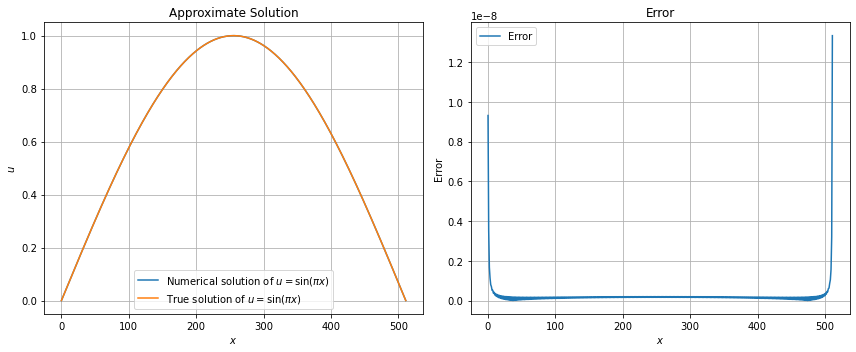

In [241]:
# Plot the solution and the error side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the approximate solution
axs[0].plot(u, label='Numerical solution of $u = \sin(\pi x)$')
axs[0].plot(u_true_values, label='True solution of $u = \sin(\pi x)$')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$u$')
axs[0].set_title('Approximate Solution')
axs[0].legend()
axs[0].grid(True)

# Plot the error
axs[1].plot(error, label='Error')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('Error')
axs[1].set_title('Error')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()